In [103]:
# imports
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL

from sktime.performance_metrics.forecasting import mean_absolute_error, mean_absolute_percentage_error
from pmdarima.preprocessing import FourierFeaturizer
from pmdarima import auto_arima

pd.options.plotting.backend = 'plotly'

# read data
df_store = pd.read_pickle('data/df_daily.pkl')
ts_company = df_store.groupby('date').sum()['sales']/1e6
ts_company.index.freq = 'D'

---
# Visual inspection
## Time plot
The dataset spans between August 2017 and January 2021, inclusively. Although more recent data is available, we decide to exclude them because since February 2021, Vietnam went through consecutive COVID lockdown periods during which, non-essential activities (including fashion retailing) had been largely inactive.

Insights from time plot:
* TREND: There is no obvious upward or downward trend in the dataset.
* SEASONALITY:
    * WEEKLY seasonality is very clear. Most peaks occur on Sundays. 
    * ANNUAL seasonality also exists:
        * The highest peaks take place at the end of November due to the major promotions of Black Friday every year.
        * The troughs occur on January/February due to Lunar New Year holidays. Total sales remains low in the 2 next months.

In [104]:
# time series plot
fig = ts_company.plot()

# Lunar New Year
fig.add_vrect(x0='2018-02-15', x1='2018-02-21', line_width=0, fillcolor="black", opacity=0.3)
fig.add_vrect(x0='2018-02-21', x1='2018-04-21', line_width=0, fillcolor="black", opacity=0.1) # 2 following months
fig.add_vrect(x0='2019-02-04', x1='2019-02-10', line_width=0, fillcolor="black", opacity=0.3)
fig.add_vrect(x0='2019-02-10', x1='2019-04-10', line_width=0, fillcolor="black", opacity=0.1) # 2 following months
fig.add_vrect(x0='2020-01-24', x1='2020-01-30', line_width=0, fillcolor="black", opacity=0.3)
fig.add_vrect(x0='2020-01-30', x1='2020-03-31', line_width=0, fillcolor="black", opacity=0.1) # 2 following months

# COVID
fig.add_vrect(x0='2020-04-01', x1='2020-04-16', line_width=0, fillcolor="red", opacity=0.3) # whole country
fig.add_vrect(x0='2020-07-28', x1='2020-09-04', line_width=0, fillcolor="red", opacity=0.3) # Da Nang

fig.update_layout(title_text='Company sales',
                  legend_title_text='Legend:')
fig.update_xaxes(title='Date')
fig.update_yaxes(title='Sum of sales')

fig.show()

## Decompose


In [140]:
stl_7 = STL(ts_company, period=7).fit()
stl_365 = STL(ts_company-stl_7.seasonal, period=365).fit()

In [165]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=5, cols=1, subplot_titles=['Observed','Trend','Weekly','Annual','Residuals'])
fig.add_trace(
    go.Scatter(x=ts_company.index, y=ts_company),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=stl_365.trend.index, y=stl_365.trend),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=stl_7.seasonal.index, y=stl_7.seasonal),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=stl_365.seasonal.index, y=stl_365.seasonal),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(x=stl_365.resid.index, y=stl_365.resid),
    row=5, col=1
)
fig.update_layout(height=600, width=1000, title_text="STL decomposition", showlegend=False)
fig.show()

In [167]:
(ts_company - stl_365.trend - stl_7.seasonal - stl_365.seasonal - stl_365.resid).sum()

3.929745417963204e-12

### Seasonality


In [41]:
ts = ts_company.loc['2019']
fig = px.line(ts,
              color=ts.index.isocalendar().week,
              width=1000, height=400,
              color_discrete_sequence=px.colors.sequential.Emrld
              )

fig.update_layout(title_text='Weekly seasonality',
                  legend_title_text='Week')
fig.update_xaxes(title='Date')
fig.update_yaxes(title='Sum of sales')

fig.show()

In [54]:
df = pd.DataFrame(ts_company.loc['2018':'2020'].resample('M').sum())
df['year'] = df.index.year
df

,sales,year
date,,
2018-01-31,14733.972777,2018
2018-02-28,18283.010609,2018
2018-03-31,9102.576005,2018
2018-04-30,12795.855608,2018
2018-05-31,12442.237614,2018
2018-06-30,11610.712441,2018
2018-07-31,14190.163218,2018
2018-08-31,14919.301452,2018
2018-09-30,11272.930206,2018


In [61]:
fig = px.line(df,
              x=df.index.month,
              y=df['sales'],
              color=df.year,
              width=1000, height=400,
              color_discrete_sequence=['light blue','green','orange'],
              )

fig.update_layout(title_text='Annual seasonality',
                  legend_title_text='Year')
fig.update_xaxes(title='Month')
fig.update_yaxes(title='Sum of sales')

fig.show()

/Users/giangphan23/OneDrive - Norges Handelshøyskole/Thesis/Sales_forecast/ap8venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.

/var/folders/kf/st4z7vm96nz8c7npjz8kjxt40000gp/T/ipykernel_4236/229809834.py:4: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



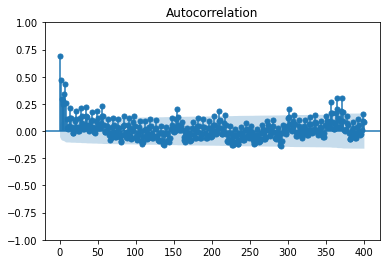

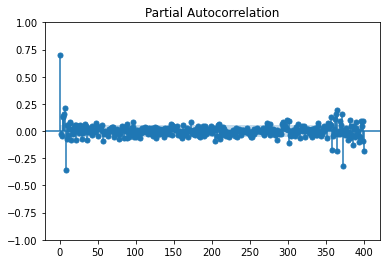

In [183]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plot_acf(ts_company, zero=False, lags=400)
fig = plot_pacf(ts_company, zero=False, lags=400)
fig.show()
